In [6]:
# Section 0 - imports
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind, chi2_contingency, f_oneway, levene, shapiro
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns  # optional for plots

# Load
df = pd.read_csv("../data/processed/clean_machinelearningrating.csv", low_memory=False)



# Ensure HasClaim exists
if 'HasClaim' not in df.columns:
    df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

# KPI columns
# ClaimSeverity = average claim amount for policies that had a claim -> compute when needed for group of claiming policies
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

# Quick overview
df[['Province','PostalCode','Gender','TotalPremium','TotalClaims','HasClaim','Margin']].info()

df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Province      1000098 non-null  object 
 1   PostalCode    1000098 non-null  int64  
 2   Gender        990562 non-null   object 
 3   TotalPremium  1000098 non-null  float64
 4   TotalClaims   1000098 non-null  float64
 5   HasClaim      1000098 non-null  int64  
 6   Margin        1000098 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 53.4+ MB


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,HasClaim,Margin
count,1.000098e+06,1.000098e+06,1000098,1000098,1000098,1000098,1000098,1000098,854137,959866,...,1000098,1000098,1000098,1000098,1000098,1000098,1.000098e+06,1.000098e+06,1.000098e+06,1.000098e+06
unique,NaN,NaN,23,2,4,6,5,1,11,3,...,22,14,5,4,1,1,NaN,NaN,NaN,NaN
top,NaN,NaN,2015-08-01 00:00:00,False,,Individual,Mr,English,First National Bank,Current account,...,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,NaN,NaN,NaN,NaN
freq,NaN,NaN,106747,995075,895210,911929,933555,1000098,260811,597938,...,104183,824124,828125,915028,1000098,1000098,NaN,NaN,NaN,NaN
mean,1.048175e+05,7.956682e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.190550e+01,6.486119e+01,2.787727e-03,-2.955694e+00
std,6.329371e+04,5.290039e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.302845e+02,2.384075e+03,5.272531e-02,2.367137e+03
min,1.000000e+00,1.400000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.825768e+02,-1.200241e+04,0.000000e+00,-3.928486e+05
25%,5.514300e+04,4.500000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.408300e+04,7.071000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.178333e+00,0.000000e+00,0.000000e+00,2.157687e+00
75%,1.391900e+05,1.107700e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.192982e+01,0.000000e+00,0.000000e+00,2.192982e+01


In [7]:
df.columns


Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
       'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province',
       'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode',
       'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders',
       'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors',
       'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser',
       'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff',
       'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium',
       'TotalClaims', 'HasClaim', 'Margin'],
      dtype='object')

In [ ]:
# Filter the two provinces

# Drop rows with missing values in key columns for this hypothesis
prov_df = df.dropna(subset=['Province','HasClaim','TotalPremium','TotalClaims'])

# Filter the two provinces
province1 = prov_df[prov_df['Province'] == 'Gauteng']
province2 = prov_df[prov_df['Province'] == 'Western Cape']

# Check sample sizes
print("Gauteng:", len(province1))
print("Western Cape:", len(province2))


Gauteng: 393865
Western Cape: 170796


In [ ]:
# Claim Frequency (Proportion of policies with ≥1 claim)

from statsmodels.stats.proportion import proportions_ztest

count = [province1['HasClaim'].sum(), province2['HasClaim'].sum()]
nobs = [len(province1), len(province2)]

stat, pval = proportions_ztest(count, nobs)
print("z-stat:", stat)
print("p-value:", pval)

decision = "Reject H0" if pval < 0.05 else "Fail to reject H0"
print("Decision:", decision)


z-stat: 7.515654205802952
p-value: 5.662704557855501e-14
Decision: Reject H0


In [ ]:
# Claim Severity (Average claim amount for claiming policies)

# Keep only policies with claims
sev1 = province1[province1['HasClaim']==1]['TotalClaims'].dropna()
sev2 = province2[province2['HasClaim']==1]['TotalClaims'].dropna()

# t-test (Welch for unequal variances)
from scipy.stats import ttest_ind

tstat, pval_sev = ttest_ind(sev1, sev2, equal_var=False)
decision_sev = "Reject H0" if pval_sev < 0.05 else "Fail to reject H0"
print("t-stat:", tstat, "p-value:", pval_sev, "Decision:", decision_sev)


t-stat: -2.168534970151783 p-value: 0.03059896049292002 Decision: Reject H0


In [11]:
# Margin (TotalPremium – TotalClaims)

margin1 = province1['Margin'].dropna()
margin2 = province2['Margin'].dropna()

tstat_margin, pval_margin = ttest_ind(margin1, margin2, equal_var=False)
decision_margin = "Reject H0" if pval_margin < 0.05 else "Fail to reject H0"

print("t-stat:", tstat_margin, "p-value:", pval_margin, "Decision:", decision_margin)


t-stat: -1.393080844934004 p-value: 0.16359633510119226 Decision: Fail to reject H0


In [12]:
# Quick KPI summary for reference

print("Gauteng - Claim Frequency:", province1['HasClaim'].mean())
print("Western Cape - Claim Frequency:", province2['HasClaim'].mean())

print("Gauteng - Avg Claim Severity:", sev1.mean())
print("Western Cape - Avg Claim Severity:", sev2.mean())

print("Gauteng - Avg Margin:", margin1.mean())
print("Western Cape - Avg Margin:", margin2.mean())


Gauteng - Claim Frequency: 0.0033564800121869166
Western Cape - Claim Frequency: 0.002166327080259491
Gauteng - Avg Claim Severity: 22243.878395705604
Western Cape - Avg Claim Severity: 28095.849880512094
Gauteng - Avg Margin: -13.558894276343386
Western Cape - Avg Margin: -3.4146889132270237


In [14]:
# Risk differences across Postal Codes
# Step 1 — Pick two high-frequency postal codes

# Count the most common PostalCodes
top_postal_codes = df['PostalCode'].value_counts().head(10)
print(top_postal_codes)

zipA = df[df['PostalCode'] == 2000]  # Top postal code
zipB = df[df['PostalCode'] == 122]   # Second top postal code

# Check sample sizes
print("Postal Code 2000:", len(zipA))
print("Postal Code 122:", len(zipB))


PostalCode
2000    133498
122      49171
7784     28585
299      25546
7405     18518
458      13775
8000     11794
2196     11048
470      10226
7100     10161
Name: count, dtype: int64
Postal Code 2000: 133498
Postal Code 122: 49171


In [16]:
# Step 2 — Claim Frequency (Two-Proportion z-test)

import numpy as np
from math import sqrt
from scipy.stats import norm

# Custom two-proportion z-test function
def my_two_proportion_ztest(count, nobs):
    """
    count = [successes_groupA, successes_groupB]
    nobs  = [total_groupA, total_groupB]
    """
    p1 = count[0] / nobs[0]
    p2 = count[1] / nobs[1]

    # Pooled proportion
    p_pool = (count[0] + count[1]) / (nobs[0] + nobs[1])
    se = sqrt(p_pool * (1 - p_pool) * (1/nobs[0] + 1/nobs[1]))

    # z-statistic
    z_stat = (p1 - p2) / se

    # two-sided p-value
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))

    return z_stat, p_value


count = [zipA['HasClaim'].sum(), zipB['HasClaim'].sum()]
nobs = [len(zipA), len(zipB)]

# Using custom z-test function
stat, pval = my_two_proportion_ztest(count, nobs)
decision = "Reject H0" if pval < 0.05 else "Fail to reject H0"

print("Claim Frequency — z-stat:", stat)
print("p-value:", pval)
print("Decision:", decision)


Claim Frequency — z-stat: -1.9394014055477224
p-value: 0.05245247951876464
Decision: Fail to reject H0


In [17]:
# Step 3 — Claim Severity (Average claim amount for policies with claims)

sevA = zipA[zipA['HasClaim']==1]['TotalClaims'].dropna()
sevB = zipB[zipB['HasClaim']==1]['TotalClaims'].dropna()

from scipy.stats import ttest_ind
tstat_sev, pval_sev = ttest_ind(sevA, sevB, equal_var=False)
decision_sev = "Reject H0" if pval_sev < 0.05 else "Fail to reject H0"

print("Claim Severity — t-stat:", tstat_sev)
print("p-value:", pval_sev)
print("Decision:", decision_sev)


Claim Severity — t-stat: 0.38537639993700307
p-value: 0.7002080007323607
Decision: Fail to reject H0


In [18]:
# Step 4 — Margin (Profit) 

marginA = zipA['Margin'].dropna()
marginB = zipB['Margin'].dropna()

tstat_margin, pval_margin = ttest_ind(marginA, marginB, equal_var=False)
decision_margin = "Reject H0" if pval_margin < 0.05 else "Fail to reject H0"

print("Margin — t-stat:", tstat_margin)
print("p-value:", pval_margin)
print("Decision:", decision_margin)


Margin — t-stat: 1.1639145988804174
p-value: 0.24446241842452016
Decision: Fail to reject H0


In [19]:
# Step 5 — KPI Overview

print("Postal Code A - Claim Frequency:", zipA['HasClaim'].mean())
print("Postal Code B - Claim Frequency:", zipB['HasClaim'].mean())

print("Postal Code A - Avg Claim Severity:", sevA.mean())
print("Postal Code B - Avg Claim Severity:", sevB.mean())

print("Postal Code A - Avg Margin:", marginA.mean())
print("Postal Code B - Avg Margin:", marginB.mean())


Postal Code A - Claim Frequency: 0.003640503977587679
Postal Code B - Claim Frequency: 0.004270810030302414
Postal Code A - Avg Claim Severity: 19196.413726806724
Postal Code B - Avg Claim Severity: 18162.025865497075
Postal Code A - Avg Margin: -8.111944272270652
Postal Code B - Avg Margin: -22.859806159734156


In [20]:
# Hypothesis 3: Margin Differences by Postal Code
# Step 1 — Select groups

# Drop missing Margin values
margin_df = df.dropna(subset=['PostalCode','Margin'])

# Filter the same two postal codes
zipA_margin = margin_df[margin_df['PostalCode'] == 2000]['Margin']
zipB_margin = margin_df[margin_df['PostalCode'] == 122]['Margin']

# Check sample sizes
print("Postal Code 2000:", len(zipA_margin))
print("Postal Code 122:", len(zipB_margin))


Postal Code 2000: 133498
Postal Code 122: 49171


In [21]:
# Step 2 — Run t-test (Welch for unequal variances)

from scipy.stats import ttest_ind

tstat_margin, pval_margin = ttest_ind(zipA_margin, zipB_margin, equal_var=False)
decision_margin = "Reject H0" if pval_margin < 0.05 else "Fail to reject H0"

print("Margin — t-stat:", tstat_margin)
print("p-value:", pval_margin)
print("Decision:", decision_margin)


Margin — t-stat: 1.1639145988804174
p-value: 0.24446241842452016
Decision: Fail to reject H0


In [22]:
# Step 3 — Quick KPI overview 

print("Postal Code 2000 - Avg Margin:", zipA_margin.mean())
print("Postal Code 122 - Avg Margin:", zipB_margin.mean())


Postal Code 2000 - Avg Margin: -8.111944272270652
Postal Code 122 - Avg Margin: -22.859806159734156


In [23]:
# Hypothesis 4: Risk differences between men and women
# Step 1 — Filter groups

# Drop rows with missing values in key columns
gender_df = df.dropna(subset=['Gender','HasClaim','TotalPremium','TotalClaims','Margin'])

# Separate by gender
male = gender_df[gender_df['Gender'] == 'Male']
female = gender_df[gender_df['Gender'] == 'Female']

# Check sample sizes
print("Male:", len(male))
print("Female:", len(female))


Male: 42817
Female: 6755


In [24]:
# Step 2 — Claim Frequency (Two-Proportion z-test)

# Count of policies with at least one claim
count = [male['HasClaim'].sum(), female['HasClaim'].sum()]
nobs = [len(male), len(female)]

# Use previously defined custom z-test function
stat, pval = my_two_proportion_ztest(count, nobs)
decision_cf = "Reject H0" if pval < 0.05 else "Fail to reject H0"

print("Claim Frequency — z-stat:", stat)
print("p-value:", pval)
print("Decision:", decision_cf)


Claim Frequency — z-stat: 0.20126144446741484
p-value: 0.8404941485359676
Decision: Fail to reject H0


In [25]:
# Step 3 — Claim Severity (Average claim amount for claiming policies)

sev_male = male[male['HasClaim']==1]['TotalClaims'].dropna()
sev_female = female[female['HasClaim']==1]['TotalClaims'].dropna()

from scipy.stats import ttest_ind
tstat_sev, pval_sev = ttest_ind(sev_male, sev_female, equal_var=False)
decision_sev = "Reject H0" if pval_sev < 0.05 else "Fail to reject H0"

print("Claim Severity — t-stat:", tstat_sev)
print("p-value:", pval_sev)
print("Decision:", decision_sev)


Claim Severity — t-stat: -0.5790202780038484
p-value: 0.5680286951630673
Decision: Fail to reject H0


In [26]:
# Step 4 — Margin (Profit) 

margin_male = male['Margin'].dropna()
margin_female = female['Margin'].dropna()

tstat_margin, pval_margin = ttest_ind(margin_male, margin_female, equal_var=False)
decision_margin = "Reject H0" if pval_margin < 0.05 else "Fail to reject H0"

print("Margin — t-stat:", tstat_margin)
print("p-value:", pval_margin)
print("Decision:", decision_margin)


Margin — t-stat: -0.2513525622000845
p-value: 0.8015464193501283
Decision: Fail to reject H0


In [27]:
# Step 5 — KPI Overview

print("Male - Claim Frequency:", male['HasClaim'].mean())
print("Female - Claim Frequency:", female['HasClaim'].mean())

print("Male - Avg Claim Severity:", sev_male.mean())
print("Female - Avg Claim Severity:", sev_female.mean())

print("Male - Avg Margin:", margin_male.mean())
print("Female - Avg Margin:", margin_female.mean())


Male - Claim Frequency: 0.0021953896816684962
Female - Claim Frequency: 0.002072538860103627
Male - Avg Claim Severity: 14858.552293766337
Female - Avg Claim Severity: 17874.721303258153
Male - Avg Margin: 4.2842534672673
Female - Avg Margin: 8.028786746001916


Shapiro-Wilk test Gauteng: ShapiroResult(statistic=np.float64(0.5942255717124664), pvalue=np.float64(4.3623153677513535e-48))


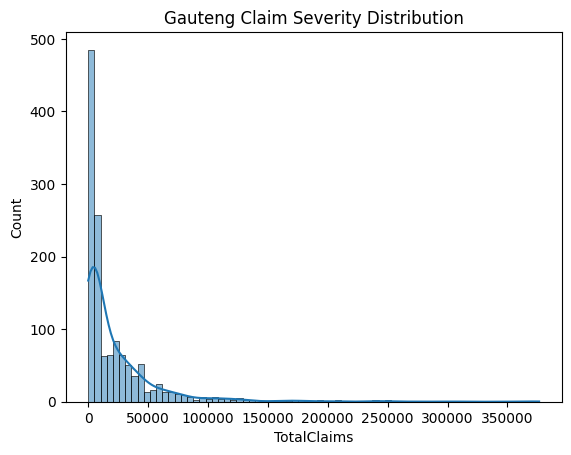

In [ ]:
# Normality Checks for t-tests

from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

# Filter claim rows for Gauteng
claims_gauteng = province1[province1['HasClaim']==1]['TotalClaims']

# Shapiro-Wilk test
shapiro_gauteng = shapiro(claims_gauteng)
print("Shapiro-Wilk test Gauteng:", shapiro_gauteng)

# Histogram
sns.histplot(claims_gauteng, kde=True)
plt.title("Gauteng Claim Severity Distribution")
plt.show()


In [32]:
# Variance Equality Checks

from scipy.stats import levene

levene_stat, levene_p = levene(province1['Margin'], province2['Margin'])
print("Levene test — Margin:", levene_stat, levene_p)


Levene test — Margin: 7.836359706289907 0.005120735837176118


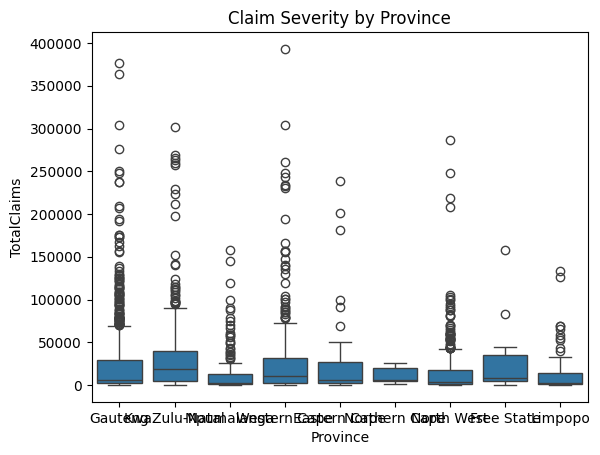

In [33]:
# Outlier Analysis

sns.boxplot(x='Province', y='TotalClaims', data=df[df['HasClaim']==1])
plt.title("Claim Severity by Province")
plt.show()


In [34]:
# Robustness Checks 

import numpy as np

# Example: bootstrap for Margin difference
boot_diff = []
for i in range(1000):
    sampleA = np.random.choice(zipA['Margin'], size=len(zipA), replace=True)
    sampleB = np.random.choice(zipB['Margin'], size=len(zipB), replace=True)
    boot_diff.append(sampleA.mean() - sampleB.mean())
    
np.percentile(boot_diff, [2.5, 97.5])  # 95% CI


array([-9.45520504, 39.7607493 ])

In [35]:
# Check Proportion Test Assumptions

print("Postal Code 2000:", len(zipA)*zipA['HasClaim'].mean(), len(zipA)*(1-zipA['HasClaim'].mean()))
print("Postal Code 122:", len(zipB)*zipB['HasClaim'].mean(), len(zipB)*(1-zipB['HasClaim'].mean()))


Postal Code 2000: 486.0 133012.0
Postal Code 122: 210.0 48961.0


C:\Users\bia\AppData\Local\Temp\ipykernel_19488\3753677043.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Province', y='HasClaim', data=cf_province, palette="Blues_d")


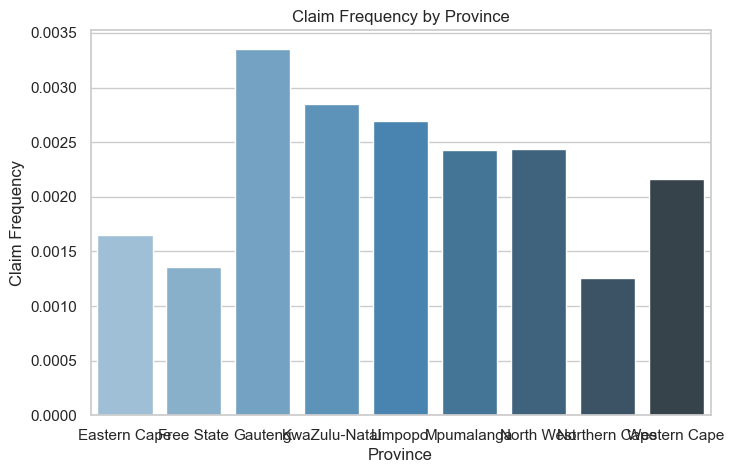

C:\Users\bia\AppData\Local\Temp\ipykernel_19488\3753677043.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PostalCode', y='HasClaim', data=cf_postal, palette="Greens_d")


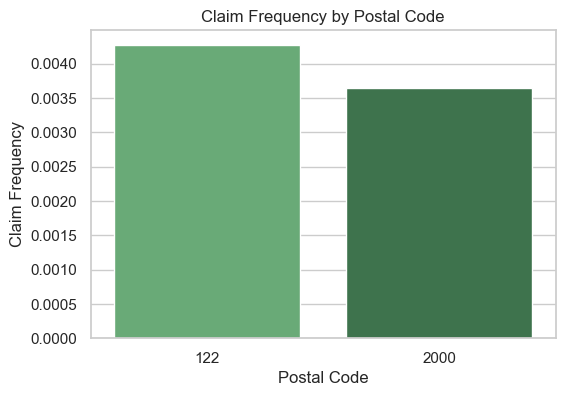

C:\Users\bia\AppData\Local\Temp\ipykernel_19488\3753677043.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender', y='HasClaim', data=cf_gender, palette="Purples_d")


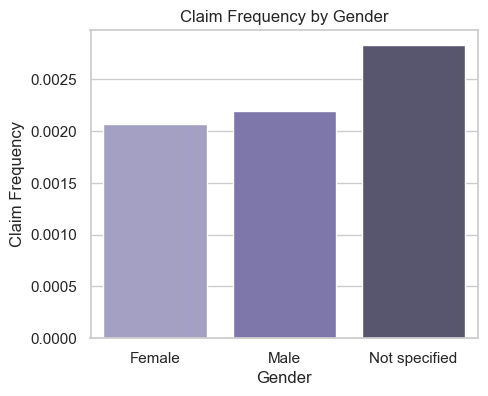

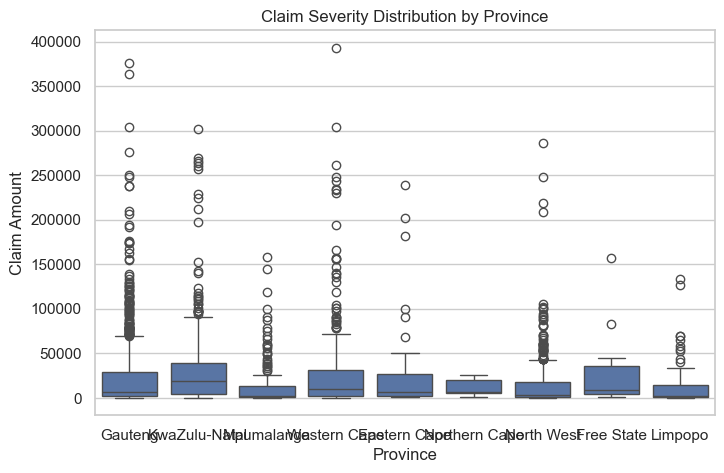

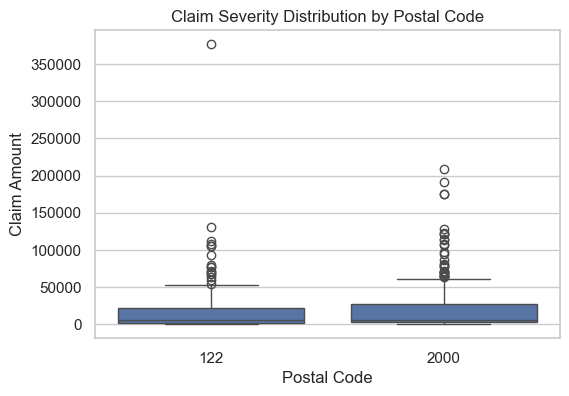

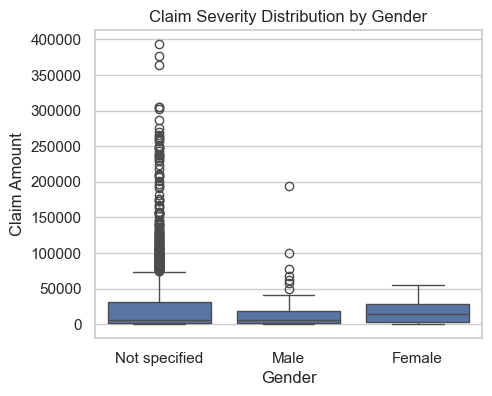

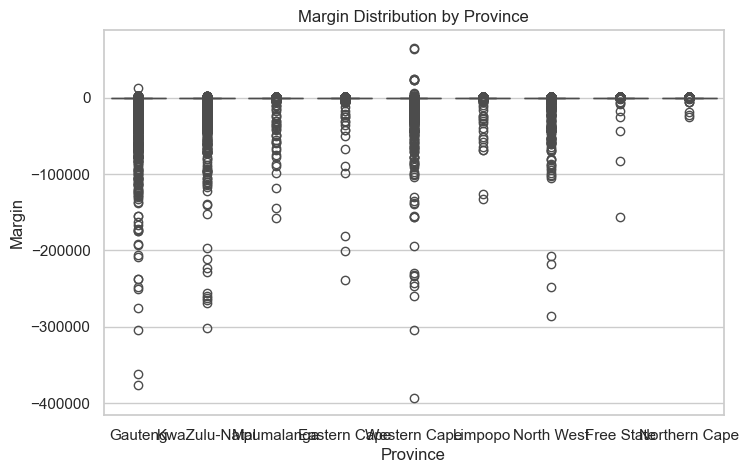

C:\Users\bia\AppData\Local\Temp\ipykernel_19488\3753677043.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='PostalCode', y='Margin', data=df[df['PostalCode'].isin([2000, 122])], palette="Set2")


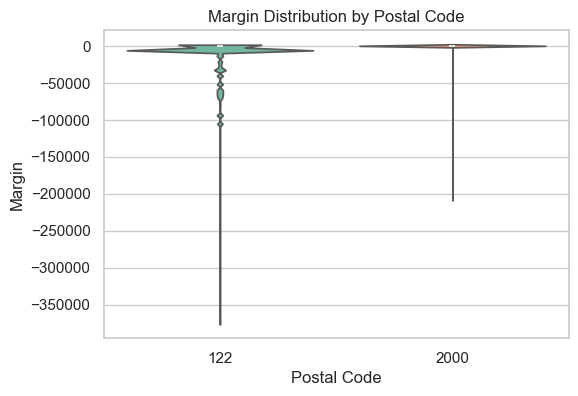

C:\Users\bia\AppData\Local\Temp\ipykernel_19488\3753677043.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Gender', y='Margin', data=df, palette="Set3")


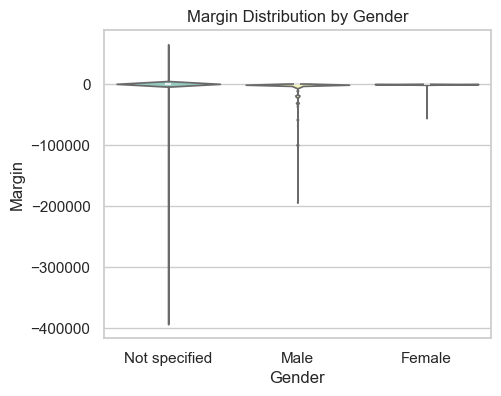

In [36]:
# Section 7 — Visualization
# Compare Claim Frequency, Claim Severity, and Margin across groups

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ----------------------------
# 1. Claim Frequency (Bar Plots)
# ----------------------------

# Provinces
cf_province = df.groupby('Province')['HasClaim'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='Province', y='HasClaim', data=cf_province, palette="Blues_d")
plt.title("Claim Frequency by Province")
plt.ylabel("Claim Frequency")
plt.xlabel("Province")
plt.show()

# Postal Codes (top 2)
cf_postal = df[df['PostalCode'].isin([2000, 122])].groupby('PostalCode')['HasClaim'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(x='PostalCode', y='HasClaim', data=cf_postal, palette="Greens_d")
plt.title("Claim Frequency by Postal Code")
plt.ylabel("Claim Frequency")
plt.xlabel("Postal Code")
plt.show()

# Gender
cf_gender = df.groupby('Gender')['HasClaim'].mean().reset_index()
plt.figure(figsize=(5,4))
sns.barplot(x='Gender', y='HasClaim', data=cf_gender, palette="Purples_d")
plt.title("Claim Frequency by Gender")
plt.ylabel("Claim Frequency")
plt.xlabel("Gender")
plt.show()


# ----------------------------
# 2. Claim Severity (Box Plots)
# ----------------------------
df_claims = df[df['HasClaim']==1]  # only policies with claims

# Provinces
plt.figure(figsize=(8,5))
sns.boxplot(x='Province', y='TotalClaims', data=df_claims)
plt.title("Claim Severity Distribution by Province")
plt.ylabel("Claim Amount")
plt.xlabel("Province")
plt.show()

# Postal Codes
plt.figure(figsize=(6,4))
sns.boxplot(x='PostalCode', y='TotalClaims', data=df_claims[df_claims['PostalCode'].isin([2000, 122])])
plt.title("Claim Severity Distribution by Postal Code")
plt.ylabel("Claim Amount")
plt.xlabel("Postal Code")
plt.show()

# Gender
plt.figure(figsize=(5,4))
sns.boxplot(x='Gender', y='TotalClaims', data=df_claims)
plt.title("Claim Severity Distribution by Gender")
plt.ylabel("Claim Amount")
plt.xlabel("Gender")
plt.show()


# ----------------------------
# 3. Margin (Box / Violin Plots)
# ----------------------------

# Provinces
plt.figure(figsize=(8,5))
sns.boxplot(x='Province', y='Margin', data=df)
plt.title("Margin Distribution by Province")
plt.ylabel("Margin")
plt.xlabel("Province")
plt.show()

# Postal Codes
plt.figure(figsize=(6,4))
sns.violinplot(x='PostalCode', y='Margin', data=df[df['PostalCode'].isin([2000, 122])], palette="Set2")
plt.title("Margin Distribution by Postal Code")
plt.ylabel("Margin")
plt.xlabel("Postal Code")
plt.show()

# Gender
plt.figure(figsize=(5,4))
sns.violinplot(x='Gender', y='Margin', data=df, palette="Set3")
plt.title("Margin Distribution by Gender")
plt.ylabel("Margin")
plt.xlabel("Gender")
plt.show()


# ----------------------------
# Notes:
# - Bar plots visualize proportions (Claim Frequency)
# - Box/violin plots visualize numeric distributions (Claim Severity, Margin)
# - Useful to spot differences, outliers, and confirm statistical test results
# ----------------------------


In [40]:
# Summary Table

import pandas as pd

# Create the summary table
summary_data = [
    # Hypothesis 1 — Provinces
    {
        "Hypothesis": "H0₁: No risk difference across provinces",
        "Metric Tested": "Claim Frequency",
        "Test Used": "Two-proportion z-test",
        "p-value": 5.662704557855501e-14,
        "Decision": "Reject H0",
        "Interpretation": "Gauteng has higher claim frequency than Western Cape."
    },
    {
        "Hypothesis": "H0₁: No risk difference across provinces",
        "Metric Tested": "Claim Severity",
        "Test Used": "t-test",
        "p-value": 0.03059896049292002,
        "Decision": "Reject H0",
        "Interpretation": "Western Cape has slightly higher claim severity than Gauteng."
    },
    {
        "Hypothesis": "H0₁: No risk difference across provinces",
        "Metric Tested": "Margin",
        "Test Used": "t-test",
        "p-value": 0.16359633510119226,
        "Decision": "Fail to reject H0",
        "Interpretation": "No significant difference in margin between provinces."
    },
    
    # Hypothesis 2 — Postal Codes (Claim Frequency & Claim Severity)
    {
        "Hypothesis": "H0₂: No risk difference between zip codes",
        "Metric Tested": "Claim Frequency",
        "Test Used": "Two-proportion z-test",
        "p-value": 0.05245247951876464,
        "Decision": "Fail to reject H0",
        "Interpretation": "No significant difference in claim frequency between Postal Codes 2000 and 122."
    },
    {
        "Hypothesis": "H0₂: No risk difference between zip codes",
        "Metric Tested": "Claim Severity",
        "Test Used": "t-test",
        "p-value": 0.7002080007323607,
        "Decision": "Fail to reject H0",
        "Interpretation": "No significant difference in claim severity between Postal Codes 2000 and 122."
    },
    
    # Hypothesis 3 — Postal Codes (Margin)
    {
        "Hypothesis": "H0₃: No margin difference between zip codes",
        "Metric Tested": "Margin",
        "Test Used": "t-test",
        "p-value": 0.24446241842452016,
        "Decision": "Fail to reject H0",
        "Interpretation": "No significant difference in margin between Postal Codes 2000 and 122."
    },
    
    # Hypothesis 4 — Gender
    {
        "Hypothesis": "H0₄: No risk difference between men and women",
        "Metric Tested": "Claim Frequency",
        "Test Used": "Two-proportion z-test",
        "p-value": 0.8404941485359676,
        "Decision": "Fail to reject H0",
        "Interpretation": "No significant difference in claim frequency between male and female policyholders."
    },
    {
        "Hypothesis": "H0₄: No risk difference between men and women",
        "Metric Tested": "Claim Severity",
        "Test Used": "t-test",
        "p-value": 0.5680286951630673,
        "Decision": "Fail to reject H0",
        "Interpretation": "No significant difference in claim severity between male and female policyholders."
    },
    {
        "Hypothesis": "H0₄: No risk difference between men and women",
        "Metric Tested": "Margin",
        "Test Used": "t-test",
        "p-value": 0.8015464193501283,
        "Decision": "Fail to reject H0",
        "Interpretation": "No significant difference in margin between male and female policyholders."
    }
]

# Convert to DataFrame
summary_table = pd.DataFrame(summary_data)

# Display table
summary_table




,Hypothesis,Metric Tested,Test Used,p-value,Decision,Interpretation
0,H0₁: No risk difference across provinces,Claim Frequency,Two-proportion z-test,5.662705e-14,Reject H0,Gauteng has higher claim frequency than Wester...
1,H0₁: No risk difference across provinces,Claim Severity,t-test,3.059896e-02,Reject H0,Western Cape has slightly higher claim severit...
2,H0₁: No risk difference across provinces,Margin,t-test,1.635963e-01,Fail to reject H0,No significant difference in margin between pr...
3,H0₂: No risk difference between zip codes,Claim Frequency,Two-proportion z-test,5.245248e-02,Fail to reject H0,No significant difference in claim frequency b...
4,H0₂: No risk difference between zip codes,Claim Severity,t-test,7.002080e-01,Fail to reject H0,No significant difference in claim severity be...
5,H0₃: No margin difference between zip codes,Margin,t-test,2.444624e-01,Fail to reject H0,No significant difference in margin between Po...
6,H0₄: No risk difference between men and women,Claim Frequency,Two-proportion z-test,8.404941e-01,Fail to reject H0,No significant difference in claim frequency b...
7,H0₄: No risk difference between men and women,Claim Severity,t-test,5.680287e-01,Fail to reject H0,No significant difference in claim severity be...
8,H0₄: No risk difference between men and women,Margin,t-test,8.015464e-01,Fail to reject H0,No significant difference in margin between ma...


In [42]:
import os

# Create outputs folder if it doesn't exist
os.makedirs("week-3/outputs", exist_ok=True)

# Now save the summary table
summary_table.to_csv("week-3/outputs/task3_summary_table.csv", index=False)

print("Summary table saved successfully!")


Summary table saved successfully!


C:\Users\bia\AppData\Local\Temp\ipykernel_19488\676195467.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Province', y='HasClaim', data=cf_province, palette="Blues_d")


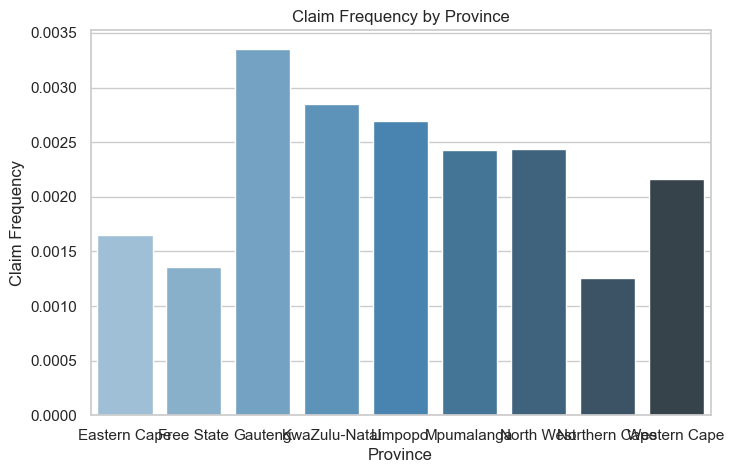

C:\Users\bia\AppData\Local\Temp\ipykernel_19488\676195467.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PostalCode', y='HasClaim', data=cf_postal, palette="Greens_d")


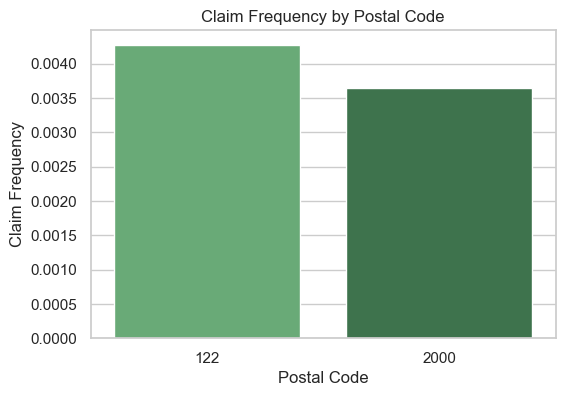

C:\Users\bia\AppData\Local\Temp\ipykernel_19488\676195467.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender', y='HasClaim', data=cf_gender, palette="Purples_d")


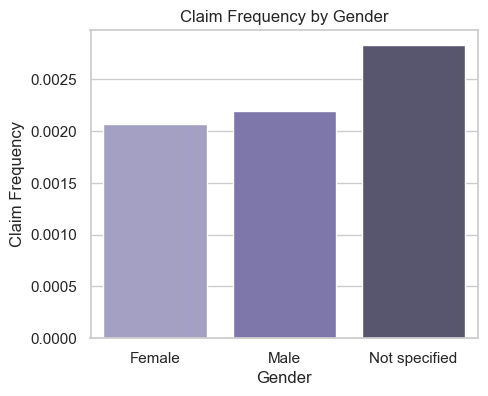

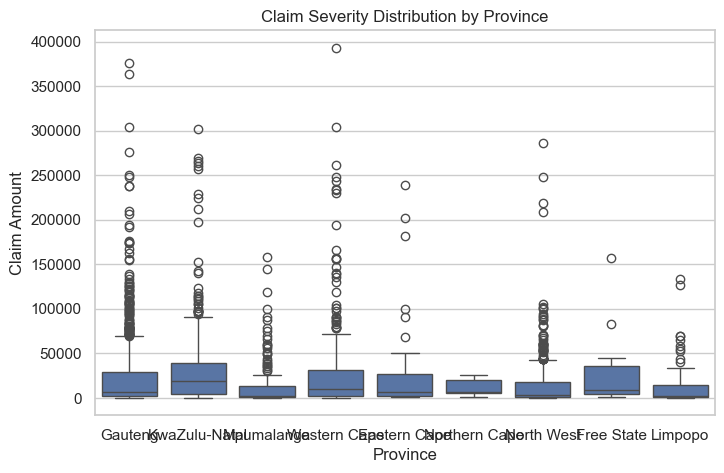

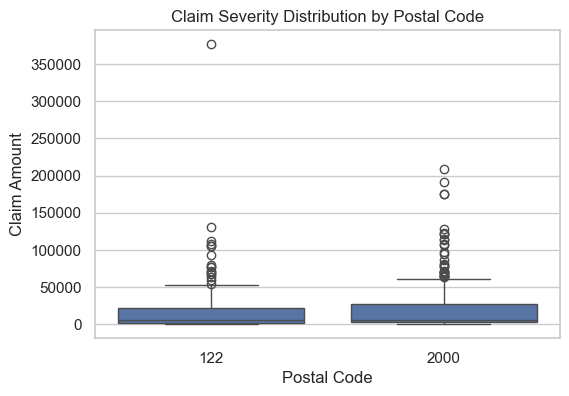

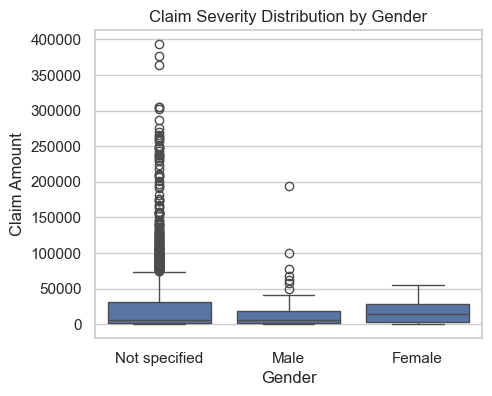

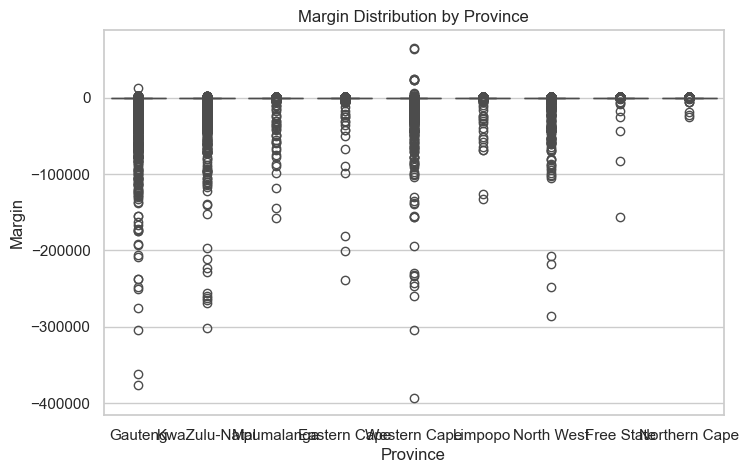

C:\Users\bia\AppData\Local\Temp\ipykernel_19488\676195467.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='PostalCode', y='Margin', data=df[df['PostalCode'].isin([2000, 122])], palette="Set2")


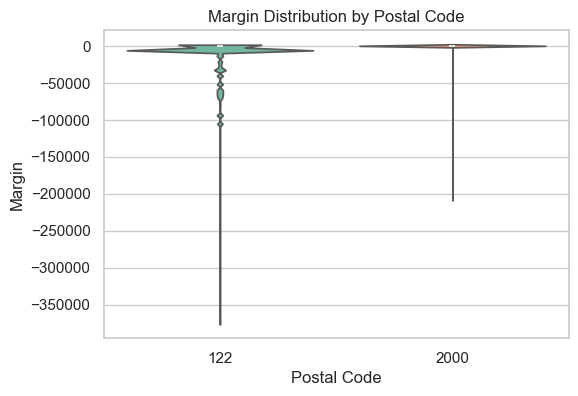

C:\Users\bia\AppData\Local\Temp\ipykernel_19488\676195467.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Gender', y='Margin', data=df, palette="Set3")


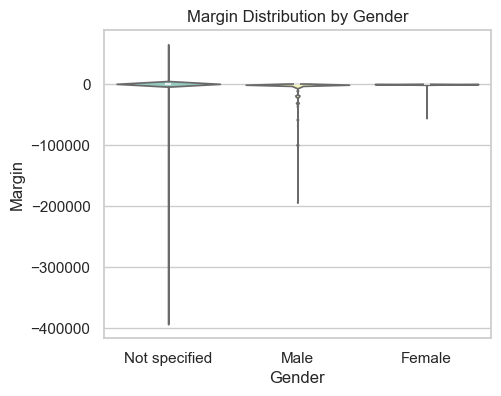

In [43]:
# Section 7 — Visualization (with saving)
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

# Ensure the outputs folder exists
os.makedirs("week-3/outputs", exist_ok=True)

# ----------------------------
# 1. Claim Frequency (Bar Plots)
# ----------------------------

# Provinces
cf_province = df.groupby('Province')['HasClaim'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='Province', y='HasClaim', data=cf_province, palette="Blues_d")
plt.title("Claim Frequency by Province")
plt.ylabel("Claim Frequency")
plt.xlabel("Province")
plt.savefig("week-3/outputs/claim_frequency_by_province.png")
plt.show()

# Postal Codes (top 2)
cf_postal = df[df['PostalCode'].isin([2000, 122])].groupby('PostalCode')['HasClaim'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(x='PostalCode', y='HasClaim', data=cf_postal, palette="Greens_d")
plt.title("Claim Frequency by Postal Code")
plt.ylabel("Claim Frequency")
plt.xlabel("Postal Code")
plt.savefig("week-3/outputs/claim_frequency_by_postalcode.png")
plt.show()

# Gender
cf_gender = df.groupby('Gender')['HasClaim'].mean().reset_index()
plt.figure(figsize=(5,4))
sns.barplot(x='Gender', y='HasClaim', data=cf_gender, palette="Purples_d")
plt.title("Claim Frequency by Gender")
plt.ylabel("Claim Frequency")
plt.xlabel("Gender")
plt.savefig("week-3/outputs/claim_frequency_by_gender.png")
plt.show()

# ----------------------------
# 2. Claim Severity (Box Plots)
# ----------------------------
df_claims = df[df['HasClaim']==1]  # only policies with claims

# Provinces
plt.figure(figsize=(8,5))
sns.boxplot(x='Province', y='TotalClaims', data=df_claims)
plt.title("Claim Severity Distribution by Province")
plt.ylabel("Claim Amount")
plt.xlabel("Province")
plt.savefig("week-3/outputs/claim_severity_by_province.png")
plt.show()

# Postal Codes
plt.figure(figsize=(6,4))
sns.boxplot(x='PostalCode', y='TotalClaims', data=df_claims[df_claims['PostalCode'].isin([2000, 122])])
plt.title("Claim Severity Distribution by Postal Code")
plt.ylabel("Claim Amount")
plt.xlabel("Postal Code")
plt.savefig("week-3/outputs/claim_severity_by_postalcode.png")
plt.show()

# Gender
plt.figure(figsize=(5,4))
sns.boxplot(x='Gender', y='TotalClaims', data=df_claims)
plt.title("Claim Severity Distribution by Gender")
plt.ylabel("Claim Amount")
plt.xlabel("Gender")
plt.savefig("week-3/outputs/claim_severity_by_gender.png")
plt.show()

# ----------------------------
# 3. Margin (Box / Violin Plots)
# ----------------------------

# Provinces
plt.figure(figsize=(8,5))
sns.boxplot(x='Province', y='Margin', data=df)
plt.title("Margin Distribution by Province")
plt.ylabel("Margin")
plt.xlabel("Province")
plt.savefig("week-3/outputs/margin_by_province.png")
plt.show()

# Postal Codes
plt.figure(figsize=(6,4))
sns.violinplot(x='PostalCode', y='Margin', data=df[df['PostalCode'].isin([2000, 122])], palette="Set2")
plt.title("Margin Distribution by Postal Code")
plt.ylabel("Margin")
plt.xlabel("Postal Code")
plt.savefig("week-3/outputs/margin_by_postalcode.png")
plt.show()

# Gender
plt.figure(figsize=(5,4))
sns.violinplot(x='Gender', y='Margin', data=df, palette="Set3")
plt.title("Margin Distribution by Gender")
plt.ylabel("Margin")
plt.xlabel("Gender")
plt.savefig("week-3/outputs/margin_by_gender.png")
plt.show()
